In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("WeatherDataProcessing") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

# Define local paths
DATASET_PATH = r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP'

RANDOM_SEED = 42

SLOW_OPERATIONS = True

# True to save the computation of dataset preprocessing, fitted pipelines and trained models to the filesystem
SAVE_COMPUTATIONS = True

# True to load the sampled dataset from the filesystem, False to compute it from the raw one
LOAD_SAMPLED_DATASET = True
SAMPLED_DATASET_PATH = r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/aggregated_sampled_weather_measurements.csv'

# True to load the encoding pipeline from the filesystem, False to compute it from scratch
LOAD_ENCODING_PIPELINE = True

# True to load pretrained models from the filesystem, False to compute them from scratch
LOAD_PRETRAINED_MODELS = True

# necessary due to limitations (training on a dataframe larger than this threshold causes issues)
MAX_TRAIN_SIZE = 999_999


In [ ]:
import pyspark
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel

from typing import *

In [ ]:
weather_conditions_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/weather_description.csv', header=True, inferSchema=True)
humidity_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/humidity.csv', header=True, inferSchema=True)
pressure_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/pressure.csv', header=True, inferSchema=True)
temperature_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/temperature.csv', header=True, inferSchema=True)
city_attributes_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/city_attributes.csv', header=True, inferSchema=True)
wind_direction_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/wind_direction.csv', header=True, inferSchema=True)
wind_speed_df = spark.read.csv(r'/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/wind_speed.csv', header=True, inferSchema=True)

In [ ]:
from pyspark.sql import DataFrame
from typing import Union

def print_dataframe_shape(dataframe: DataFrame) -> None:
    rows_count = dataframe.count()
    columns_count = len(dataframe.columns)

    print(f'The shape of the dataset is {rows_count} rows by {columns_count} columns', end='\n\n')

# Example usage:
# Assuming `DataFrame` is imported properly
# and you have a DataFrame named `df`
# print_dataframe_shape(df)


In [ ]:
print_dataframe_shape(city_attributes_df)

The shape of the dataset is 36 rows by 4 columns



In [ ]:
city_attributes_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [ ]:
city_attributes_df.head(5)

[Row(City='Vancouver', Country='Canada', Latitude=49.24966, Longitude=-123.119339),
 Row(City='Portland', Country='United States', Latitude=45.523449, Longitude=-122.676208),
 Row(City='San Francisco', Country='United States', Latitude=37.774929, Longitude=-122.419418),
 Row(City='Seattle', Country='United States', Latitude=47.606209, Longitude=-122.332069),
 Row(City='Los Angeles', Country='United States', Latitude=34.052231, Longitude=-118.243683)]

In [ ]:
print_dataframe_shape(weather_conditions_df)

The shape of the dataset is 45253 rows by 37 columns



In [ ]:
weather_conditions_df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- Vancouver: string (nullable = true)
 |-- Portland: string (nullable = true)
 |-- San Francisco: string (nullable = true)
 |-- Seattle: string (nullable = true)
 |-- Los Angeles: string (nullable = true)
 |-- San Diego: string (nullable = true)
 |-- Las Vegas: string (nullable = true)
 |-- Phoenix: string (nullable = true)
 |-- Albuquerque: string (nullable = true)
 |-- Denver: string (nullable = true)
 |-- San Antonio: string (nullable = true)
 |-- Dallas: string (nullable = true)
 |-- Houston: string (nullable = true)
 |-- Kansas City: string (nullable = true)
 |-- Minneapolis: string (nullable = true)
 |-- Saint Louis: string (nullable = true)
 |-- Chicago: string (nullable = true)
 |-- Nashville: string (nullable = true)
 |-- Indianapolis: string (nullable = true)
 |-- Atlanta: string (nullable = true)
 |-- Detroit: string (nullable = true)
 |-- Jacksonville: string (nullable = true)
 |-- Charlotte: string (nullable = true)
 |-- M

In [ ]:
weather_conditions_df[weather_conditions_df.columns[:5]].head(5)

[Row(datetime=datetime.datetime(2012, 10, 1, 12, 0), Vancouver=None, Portland=None, San Francisco=None, Seattle=None),
 Row(datetime=datetime.datetime(2012, 10, 1, 13, 0), Vancouver='mist', Portland='scattered clouds', San Francisco='light rain', Seattle='sky is clear'),
 Row(datetime=datetime.datetime(2012, 10, 1, 14, 0), Vancouver='broken clouds', Portland='scattered clouds', San Francisco='sky is clear', Seattle='sky is clear'),
 Row(datetime=datetime.datetime(2012, 10, 1, 15, 0), Vancouver='broken clouds', Portland='scattered clouds', San Francisco='sky is clear', Seattle='sky is clear'),
 Row(datetime=datetime.datetime(2012, 10, 1, 16, 0), Vancouver='broken clouds', Portland='scattered clouds', San Francisco='sky is clear', Seattle='sky is clear')]

In [ ]:
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

In [ ]:
from pyspark.sql import functions as F

def filter_dataframe_by_city_column(dataframe: DataFrame,
                                    city_name: str,
                                    new_column_name: str) -> DataFrame:
    '''
    Args:
        - dataframe: a `DataFrame` with a datetime column and n cities columns,
                     where the records are the related hourly measurements
        - city_name: city name between the ones in the dataframe
        - new_column_name: name to replace the city name

    Returns:
        a new `DataFrame` with:
            - the datetime column
            - a single column of measurements related to the `city_name`
              and renamed as `new_column_name`
    '''
    return dataframe.select([DATETIME_COL, city_name]) \
                    .withColumnRenamed(city_name, new_column_name)


In [ ]:
def join_dataframes(dataframes: List[DataFrame], column_name: str) -> DataFrame:
    '''
    Args:
        - dataframse: a list of `DataFrame` to be joined
        - column_name: the column over which the records should be joined

    Returns:
        a new dataframes resulting from the join of all the dataframes
        over the `column_name` column
    '''
    joined_df = dataframes[0]

    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, [column_name])

    return joined_df

In [ ]:
from pyspark.sql.functions import lit
from functools import reduce

# Initialize an empty DataFrame to store the weather measurements
weather_measurements_df = None

# Iterate over all the records in the cities DataFrame
for row in city_attributes_df.collect():
    city = row['City']
    country = row['Country']
    latitude = row['Latitude']
    longitude = row['Longitude']

    # Compute a list of DataFrames, one for each type of measurement in the city
    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temperature_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_direction_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_speed_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_conditions_df, city, WEATHER_CONDITION_COL)
    ]

    # Define a function to join DataFrames
    def join_dataframes(df1, df2):
        return df1.join(df2, DATETIME_COL)

    # Compute a DataFrame that includes all the data about the measurements in the city
    joined_df = reduce(join_dataframes, dataframes) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    # Union the DataFrame with the ones computed in the previous iterations
    if weather_measurements_df is None:
        weather_measurements_df = joined_df
    else:
        weather_measurements_df = weather_measurements_df.union(joined_df)


In [ ]:
print_dataframe_shape(weather_measurements_df)

The shape of the dataset is 1640268 rows by 11 columns



In [ ]:
weather_measurements_df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- weather_condition: string (nullable = true)
 |-- city: string (nullable = false)
 |-- country: string (nullable = false)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)



In [ ]:
if SLOW_OPERATIONS: weather_measurements_df.show(5)

24/04/22 17:41:25 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-01 12:00:00|    null|    null|         null|          null|      null|             null|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 13:00:00|    76.0|    null|       284.63|           0.0|       0.0|             mist|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 14:00:00|    76.0|    null| 284.62904131|           6.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 15:00:00|    76.0|    null|284.626997923|          20.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 16:00:00|    77.0|    null|28

In [ ]:
#if SLOW_OPERATIONS: weather_measurements_df.describe().to_koalas().transpose()

from pyspark.sql.functions import col

# Check if SLOW_OPERATIONS is True
if SLOW_OPERATIONS:
    # Describe the DataFrame
    description_df = weather_measurements_df.describe()

    # Transpose the DataFrame
    transposed_description_df = description_df.select(*([col("summary")] + [col(col_name).alias(col_name) for col_name in description_df.columns[1:]])).toDF(*description_df.columns)

    # Show the transposed description
    #transposed_description_df.show()


In [ ]:
if SLOW_OPERATIONS:
    for c in weather_measurements_df.columns:
        print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')


Missing values of column `datetime` count: 0


Missing values of column `humidity` count: 28868


Missing values of column `pressure` count: 16680


Missing values of column `temperature` count: 8030


Missing values of column `wind_direction` count: 7975


Missing values of column `wind_speed` count: 7993


Missing values of column `weather_condition` count: 7955
Missing values of column `city` count: 0
Missing values of column `country` count: 0
Missing values of column `latitude` count: 0
Missing values of column `longitude` count: 0


In [ ]:
not_null_weather_measurements_df = weather_measurements_df.dropna()

In [ ]:
if SLOW_OPERATIONS: not_null_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show(truncate=False)

24/04/22 17:42:26 WARN DAGScheduler: Broadcasting large task binary with size 1289.4 KiB


+----------------------------+------+
|weather_condition           |count |
+----------------------------+------+
|fog                         |16247 |
|very heavy rain             |1001  |
|proximity shower rain       |2339  |
|few clouds                  |134584|
|heavy shower snow           |336   |
|light rain                  |127984|
|light intensity drizzle     |8110  |
|light intensity shower rain |3695  |
|broken clouds               |168373|
|overcast clouds             |135049|
|light snow                  |14554 |
|scattered clouds            |144223|
|thunderstorm with heavy rain|396   |
|thunderstorm with light rain|1179  |
|heavy intensity rain        |14075 |
|moderate rain               |43296 |
|light intensity drizzle rain|41    |
|sky is clear                |646304|
|snow                        |3156  |
|light shower snow           |1029  |
+----------------------------+------+
only showing top 20 rows



In [ ]:
def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    '''
    Args:
        - weather_conditions: an iterable collection of string weather conditions to be aggregated

    Returns:
        a dictionary that goes from the original weather condition name to one among the following:
            - thunderstorm
            - rainy
            - snowy
            - cloudy
            - foggy
            - sunny
    '''

    weather_conditions_dict = dict()

    for weather_condition in weather_conditions:

        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif 'cloud' in weather_condition_lowered:
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            weather_conditions_dict[weather_condition] = 'foggy'
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            weather_conditions_dict[weather_condition] = 'sunny'

    return weather_conditions_dict

In [ ]:
from pyspark.sql.functions import collect_set, explode

# Select distinct values from the not_null_weather_measurements_df DataFrame for the WEATHER_CONDITION_COL column
distinct_conditions_df = not_null_weather_measurements_df.select(collect_set(WEATHER_CONDITION_COL).alias(WEATHER_CONDITION_COL))

# Explode the array of distinct conditions into separate rows
distinct_conditions_exploded_df = distinct_conditions_df.select(explode(col(WEATHER_CONDITION_COL)).alias(WEATHER_CONDITION_COL))

# Collect distinct conditions as a list
distinct_conditions_list = distinct_conditions_exploded_df.select(WEATHER_CONDITION_COL).distinct().collect()

# Flatten the list
weather_conditions_all = [row[WEATHER_CONDITION_COL] for row in distinct_conditions_list]

24/04/22 17:42:44 WARN DAGScheduler: Broadcasting large task binary with size 1277.2 KiB


In [ ]:
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

In [ ]:
weather_measurements_aggregated_df = not_null_weather_measurements_df.replace(weather_conditions_dict)

In [ ]:
WEATHER_CONDITIONS = set(weather_conditions_dict.values())

weather_measurements_aggregated_df = weather_measurements_aggregated_df \
    .filter(weather_measurements_aggregated_df[WEATHER_CONDITION_COL].isin(WEATHER_CONDITIONS))

In [ ]:
if SLOW_OPERATIONS: weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_COL).count().show()

24/04/22 17:43:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+-----------------+------+
|weather_condition| count|
+-----------------+------+
|            rainy|203624|
|            snowy| 21500|
|            sunny|646304|
|           cloudy|582229|
|     thunderstorm| 10883|
|            foggy|139389|
+-----------------+------+



24/04/22 17:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1565.8 KiB


In [ ]:
def count_weather_condition_occurrences(dataframe: DataFrame, class_name: str) -> int:
    '''
    Args:
        - dataframe: a `DataFrame` which contains a column `WEATHER_CONDITION_COL`
        - class_name: the class name to count the occurences of

    Returns:
        the total number of `class_name` occurences inside `dataframe`
    '''
    return dataframe.filter(dataframe[WEATHER_CONDITION_COL] == class_name).count()

In [ ]:
def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    '''
    Args:
        - dataframe: a `DataFrame` of weather measurements which contains a column `WEATHER_CONDITION_COL`

    Returns:
        a dictionary that goes from a weather condition to its fraction
        that should be sampled in order to match the occurences of the minority class
    '''

    rainy_cnt = count_weather_condition_occurrences(dataframe, 'rainy')
    snowy_cnt = count_weather_condition_occurrences(dataframe, 'snowy')
    sunny_cnt = count_weather_condition_occurrences(dataframe, 'sunny')
    foggy_cnt = count_weather_condition_occurrences(dataframe, 'foggy')
    cloudy_cnt = count_weather_condition_occurrences(dataframe, 'cloudy')
    thunderstorm_cnt = count_weather_condition_occurrences(dataframe, 'thunderstorm')

    minority_class_cnt = np.min([rainy_cnt, snowy_cnt, sunny_cnt, cloudy_cnt, foggy_cnt, thunderstorm_cnt])

    return {
        'rainy': minority_class_cnt / rainy_cnt,
        'snowy': minority_class_cnt / snowy_cnt,
        'sunny': minority_class_cnt / sunny_cnt,
        'foggy': minority_class_cnt / foggy_cnt,
        'cloudy': minority_class_cnt / cloudy_cnt,
        'thunderstorm': minority_class_cnt / thunderstorm_cnt
    }

In [ ]:
from pyspark.sql.functions import col
import os
#SAMPLED_DATASET_PATH = r'C:\Users\91701\Downloads\0.csv'
# Load sampled dataset if LOAD_SAMPLED_DATASET is True, otherwise sample the DataFrame
if LOAD_SAMPLED_DATASET:
    folder_path = r"/Users/sakethreddyvallapureddy/Desktop/chai_BDP/DATASET_BDP/aggregated_sampled_weather_measurements.csv"

    # Get a list of CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

    # Iterate over each CSV file and read it into a DataFrame
    dfs = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = spark.read.options(header='true', inferSchema='true').csv(file_path)
        dfs.append(df)

    # Union all DataFrames together to create a single DataFrame
    sampled_weather_measurements_df = dfs[0]  # Initialize with the first DataFrame
    for df in dfs[1:]:
        sampled_weather_measurements_df = sampled_weather_measurements_df.union(df)

    # Show the combined DataFrame
    sampled_weather_measurements_df.show()
    #sampled_weather_measurements_df = spark.read.format("csv").option("header", "true").load(SAMPLED_DATASET_PATH)
else:
    sampled_weather_measurements_df = not_null_weather_measurements_df.sampleBy(
        WEATHER_CONDITION_COL,
        fractions=get_undersampling_fracs(not_null_weather_measurements_df),
        seed=RANDOM_SEED
    )


+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------------+---------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|      country| latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------------+---------+-----------+
|2014-07-17 17:00:00|    16.0|  1012.0|       308.69|         190.0|       3.0|     thunderstorm|Las Vegas|United States|36.174969|-115.137222|
|2014-07-17 19:00:00|    11.0|  1011.0|        312.1|         169.0|       1.0|            sunny|Las Vegas|United States|36.174969|-115.137222|
|2014-07-23 04:00:00|     6.0|  1013.0|       308.49|         250.0|       4.0|            sunny|Las Vegas|United States|36.174969|-115.137222|
|2014-07-26 01:00:00|    17.0|  1009.0|       312.11|         230.0|       5.0|     thunderstorm|Las Vegas|United States|36.174969|-115.

In [ ]:
sampled_weather_measurements_df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- weather_condition: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [ ]:
if SAVE_COMPUTATIONS and not LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df.write.csv(SAMPLED_DATASET_PATH,
                                              mode='overwrite',
                                              header=True)

In [ ]:
sampled_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show()

+-----------------+-----+
|weather_condition|count|
+-----------------+-----+
|            rainy| 8373|
|            snowy| 8622|
|            sunny| 8656|
|           cloudy| 8644|
|     thunderstorm| 8553|
|            foggy| 8581|
+-----------------+-----+



In [ ]:
# Describe the DataFrame
description_df = sampled_weather_measurements_df.describe()

# Collect distinct summary values
summary_values = [row["summary"] for row in description_df.select("summary").distinct().collect()]

# Transpose the DataFrame using pivot
transposed_df = description_df.groupBy().pivot("summary").agg(*[first(col(c)).alias(c) for c in description_df.columns if c != "summary"])

# Show the transposed DataFrame
transposed_df.show()

24/04/22 17:43:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+--------------+-----------------+--------------------+----------------+-----------------------+----------+-------------+--------------+---------------+------------+------------+---------------+------------------+--------------+---------------------+---------+-------------+------------+-------------+-----------------+-----------------+-----------------+-------------------+------------------+----------------------+---------+------------+------------------+------------------+------------+------------+---------------+------------------+--------------+---------------------+-----------+-----------+------------+-------------+------------------+------------------+------------------+---------------------+------------------+------------------------+-----------+--------------+-----------------+-----------------+
|count_humidity|count_pressure|count_temperature|count_wind_direction|count_wind_speed|count_weather_condition|count_city|count_country|count_latitude|count_longitude|max_

In [ ]:
train_df, test_df = sampled_weather_measurements_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
train_df = train_df.limit(MAX_TRAIN_SIZE)

In [ ]:
print(f'Train set size:  {train_df.count()} instances')
print(f'Test set size:   {test_df.count()} instances')

Train set size:  41293 instances
Test set size:   10136 instances


In [ ]:
NUMERICAL_FEATURES = [HUMIDITY_COL,
                      PRESSURE_COL,
                      TEMPERATURE_COL,
                      WIND_DIRECTION_COL,
                      WIND_SPEED_COL,
                      LATITUDE_COL,
                      LONGITUDE_COL,]

CATEGORICAL_FEATURES = [CITY_COL,
                     COUNTRY_COL]

TARGET_VARIABLE_COL = "weather_condition"
PREDICTED_TARGET_VARIABLE_COL = f"predicted_{TARGET_VARIABLE_COL}"

LABEL_COL = "label"
PREDICTION_COL = "prediction"

FEATURES_COL = "features"
SCALED_FEATURES_COL = f"scaled_{FEATURES_COL}"

In [ ]:
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:

    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")

    model.write().overwrite().save(path)

In [ ]:
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from typing import List

# Define your constants
LABEL_COL = "label"
FEATURES_COL = "features"
SCALED_FEATURES_COL = "scaled_features"

# Define your encoding pipeline function
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      features_col: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:
    '''
    Args:
        - dataframe: the input `DataFrame` to fit the pipeline
        - numerical_features: the list of column names in `dataframe` corresponding to numerical features
        - categorical_features: the list of column names in `dataframe` corresponding to categorical features
        - target_variable: the column name in `dataframe` corresponding to the target variable
        - with_std: whether to scale the data to unit standard deviation or not (True by default)
        - with_mean: whether to center the data with mean before scaling (False by default)

    Returns:
        the encoding pipeline fitted with `dataframe`
    '''

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)

    # Create a list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep')
                for c in categorical_features]

    # Create the one-hot encoder for the list of features just indexed (this encoder will keep unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers],
                            handleInvalid='keep')

    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)

    # Create a second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL,
                            withStd=with_std, withMean=with_mean)

    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(dataframe)

    return transformer

# Instantiate the encoding pipeline
data_encoder = encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL,FEATURES_COL)

# Transform train_df using the encoding pipeline
encoded_train_df = data_encoder.transform(train_df)

# Show the encoded DataFrame
encoded_train_df.show(5)


+-------------------+--------+--------+-------------+--------------+----------+-----------------+-----------+-------------+---------+-----------+-----+------------+---------------+--------------------+-----------------------+--------------------+--------------------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|       city|      country| latitude|  longitude|label|city_indexed|country_indexed|city_indexed_encoded|country_indexed_encoded|            features|     scaled_features|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+-----------+-------------+---------+-----------+-----+------------+---------------+--------------------+-----------------------+--------------------+--------------------+
|2012-10-01 15:00:00|    23.0|  1013.0|296.631487354|           9.0|       2.0|            sunny|    Phoenix|United States| 33.44838|-112.074043|  0.0|        29.0|            0.0|     (37,[29],[1

In [ ]:
def encoding_pipeline(dataframe, numerical_features, categorical_features, target_variable_col,features_col):
    # Define encoding stages (e.g., StringIndexer, OneHotEncoder, VectorAssembler)
    # Add stages to a list
    encoding_stages = []

    # Add StringIndexer for categorical features
    for categorical_feature in categorical_features:
        string_indexer = StringIndexer(inputCol=categorical_feature, outputCol=f"{categorical_feature}_index")
        encoding_stages.append(string_indexer)

    # Add OneHotEncoder for indexed categorical features
    indexed_categorical_features = [f"{categorical_feature}_index" for categorical_feature in categorical_features]
    one_hot_encoder = OneHotEncoder(inputCols=indexed_categorical_features, outputCols=[f"{categorical_feature}_onehot" for categorical_feature in categorical_features])
    encoding_stages.append(one_hot_encoder)

    # Combine numerical and one-hot encoded categorical features into a single feature vector
    assembler_inputs = numerical_features + [f"{categorical_feature}_onehot" for categorical_feature in categorical_features]
    vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    encoding_stages.append(vector_assembler)

    # Create the encoding pipeline
    encoding_pipeline = Pipeline(stages=encoding_stages)

    # Fit the pipeline on the training data
    data_encoder = encoding_pipeline.fit(dataframe)

    return data_encoder

In [ ]:
# Save the encoding pipeline if SAVE_COMPUTATIONS is True and LOAD_ENCODING_PIPELINE is False
if SAVE_COMPUTATIONS and not LOAD_ENCODING_PIPELINE:
    save_pyspark_model(data_encoder)

In [ ]:
# Transform train_df and test_df using the encoding pipeline
encoded_train_df = data_encoder.transform(train_df)
encoded_test_df = data_encoder.transform(test_df)

In [ ]:
encoded_train_df.select([FEATURES_COL, SCALED_FEATURES_COL, LABEL_COL]).show(5)

+--------------------+--------------------+-----+
|            features|     scaled_features|label|
+--------------------+--------------------+-----+
|(48,[29,37,41,42,...|(48,[29,37,41,42,...|  0.0|
|(48,[28,37,41,42,...|(48,[28,37,41,42,...|  0.0|
|(48,[29,37,41,42,...|(48,[29,37,41,42,...|  0.0|
|(48,[27,37,41,42,...|(48,[27,37,41,42,...|  2.0|
|(48,[28,37,41,42,...|(48,[28,37,41,42,...|  4.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Train a new RandomForestClassifier model
rnd_forest_model = RandomForestClassifier(featuresCol=FEATURES_COL).setLabelCol(LABEL_COL).fit(encoded_train_df)


In [ ]:
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

In [ ]:
from pyspark.ml.feature import IndexToString

predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

In [ ]:
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def eval_predictions(predictions):
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="precisionByLabel")
    precision = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="recallByLabel")
    recall = evaluator.evaluate(predictions)

    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')

In [ ]:
def plot_confusion_matrix(predictions_df: DataFrame,
                          normalize: bool = False,
                          title: str = None):
    '''
    Plots a Confusion Matrix computed on the given `DataFrame`

    Args:
        - predictions_df: a `DataFrame` that has at least a `label` and a `prediction` column
        - normalize: True to normalize the values in the Confusion Matrix, False otherwise
        - title: optional title to append on top of the plotted Confusion Matrix
    '''

    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels

    # Extract labels and predictions as numpy arrays from Spark DataFrame
    labels = predictions_df.select(LABEL_COL).rdd.map(lambda x: x[0]).collect()
    predictions = predictions_df.select(PREDICTION_COL).rdd.map(lambda x: x[0]).collect()

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions, labels=None)

    # Only use the labels that appear in the data
    classes = unique_labels(labels, predictions)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           xlabel='Predicted label', ylabel='True label',
           title=title)

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

Accuracy: 0.48865430149960537
Precision: 0.5036855036855037
Recall: 0.36760310818888225
F1-score: 0.4250172771250864


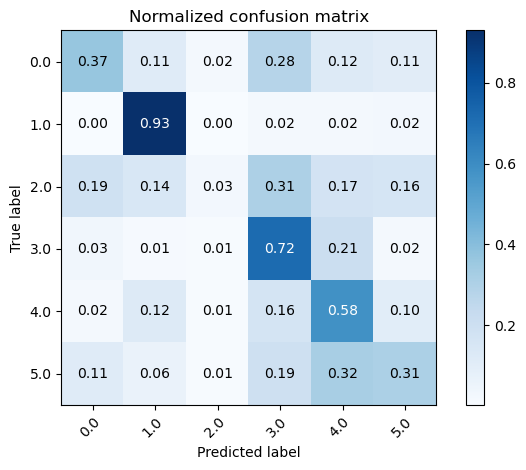

In [ ]:
eval_predictions(rnd_forest_predictions)
plot_confusion_matrix(rnd_forest_predictions, normalize=True)

In [ ]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Train a new LogisticRegression model
log_reg_model = LogisticRegression(featuresCol=FEATURES_COL, labelCol=LABEL_COL)

# Fit the model to the training data
log_reg_model = log_reg_model.fit(encoded_train_df)

# Use the trained model to make predictions on the test data
log_reg_predictions = log_reg_model.transform(encoded_test_df)


24/04/22 17:43:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/22 17:43:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy: 0.5259471191791634
Precision: 0.5285620485883126
Recall: 0.4811715481171548
F1-score: 0.5037546933667084


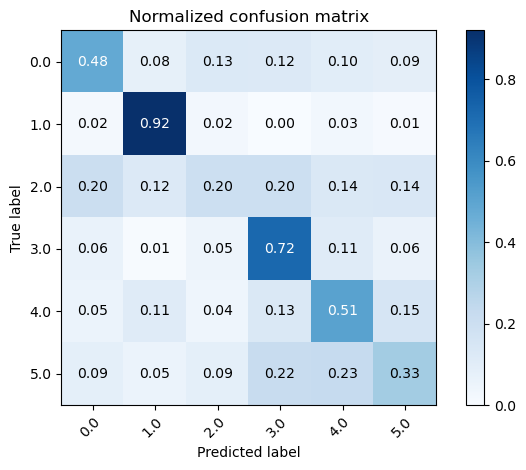

In [ ]:
eval_predictions(log_reg_predictions)
plot_confusion_matrix(log_reg_predictions, normalize=True)

In [ ]:
API_KEY = '0a7121469bec87d1db2d4bb6c2960cb9'
CITY_NAMES = ['Vancouver']

openweather_model = rnd_forest_model

OPENWEATHER_FORECAST_COL = 'openweather_forecast'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import lit
import requests

def get_5_days_forecasts_df(city_name: str, api_key: str) -> DataFrame:
    # Define the city name and API key
    city_name = "Vancouver"  # Replace with the desired city name
    api_key = "0a7121469bec87d1db2d4bb6c2960cb9"  # Replace with your OpenWeather API key

    # Construct the API URL
    API_URL = f'http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}'

    # Make the request to the API and parse the response
    res = requests.get(API_URL).json()

    # Print the response
    print(res)

    # Extract the coordinates
    coord = res['city']['coord']
    latitude = float(coord['lat'])
    longitude = float(coord['lon'])

    # Define the schema using a list of Row objects
    forecasts = []
    for forecast in res['list']:
        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather'][0]  # Extract first element from weather list

        datetime = forecast['dt_txt']
        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])
        weather_condition = weather['main']

        # Create a Row object for each forecast entry
        forecast_row = Row(
            datetime=datetime,
            humidity=humidity,
            pressure=pressure,
            temperature=temperature,
            wind_direction=wind_direction,
            wind_speed=wind_speed,
            weather_condition=weather_condition,
            city=city_name,
            latitude=latitude,
            longitude=longitude
        )
        forecasts.append(forecast_row)

    # Convert the list of Row objects to a DataFrame
    forecasts_df = spark.createDataFrame(forecasts)

    return forecasts_df

# Define the API key and city names as constants
API_KEY = '0ca1862fb521371f682fec8adbf2bfd6'  # Replace with your OpenWeatherMap API key
CITY_NAMES = ['Vancouver']  # Replace with the list of city names you want to query

# Get the 5-day forecasts for each city and concatenate them into a single DataFrame
dfs = [get_5_days_forecasts_df(city_name, API_KEY) for city_name in CITY_NAMES]

# Use the PySpark function `unionAll` to concatenate multiple DataFrames
openweather_forecasts_df = dfs[0]
for df in dfs[1:]:
    openweather_forecasts_df = openweather_forecasts_df.unionAll(df)

# The `openweather_forecasts_df` now contains the concatenated 5-day forecasts for all the cities in the list of CITY_NAMES

{'cod': '200', 'message': 0, 'cnt': 40, 'list': [{'dt': 1713830400, 'main': {'temp': 286.57, 'feels_like': 285.4, 'temp_min': 285.04, 'temp_max': 286.57, 'pressure': 1020, 'sea_level': 1020, 'grnd_level': 1010, 'humidity': 55, 'temp_kf': 1.53}, 'weather': [{'id': 801, 'main': 'Clouds', 'description': 'few clouds', 'icon': '02d'}], 'clouds': {'all': 16}, 'wind': {'speed': 3.14, 'deg': 290, 'gust': 3.85}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'd'}, 'dt_txt': '2024-04-23 00:00:00'}, {'dt': 1713841200, 'main': {'temp': 284.9, 'feels_like': 283.72, 'temp_min': 283.68, 'temp_max': 284.9, 'pressure': 1018, 'sea_level': 1018, 'grnd_level': 1008, 'humidity': 61, 'temp_kf': 1.22}, 'weather': [{'id': 801, 'main': 'Clouds', 'description': 'few clouds', 'icon': '02d'}], 'clouds': {'all': 17}, 'wind': {'speed': 2.66, 'deg': 322, 'gust': 4.24}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'd'}, 'dt_txt': '2024-04-23 03:00:00'}, {'dt': 1713852000, 'main': {'temp': 283.17, 'feels_like': 281.98

In [ ]:
# Perform aggregation using groupBy and count functions
aggregation_df = df.groupBy(TARGET_VARIABLE_COL).agg(count("*").alias("count"))

# Convert the aggregation DataFrame to a dictionary
weather_conditions_dict = dict(aggregation_df.collect())

# Show the resulting aggregation dictionary
print(weather_conditions_dict)

{'rainy': 1189, 'snowy': 881, 'sunny': 1036, 'cloudy': 1168, 'thunderstorm': 2136, 'foggy': 1158}


In [ ]:
WEATHER_CONDITIONS

{'cloudy', 'foggy', 'rainy', 'snowy', 'sunny', 'thunderstorm'}

In [ ]:
# Get the list of column names in the DataFrame
column_names = openweather_forecasts_df.columns

# Print the list of column names
print("Column Names:", column_names)


Column Names: ['datetime', 'humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed', 'weather_condition', 'city', 'latitude', 'longitude']


In [ ]:
# Show distinct values in the target column
openweather_forecasts_df.select(F.col(TARGET_VARIABLE_COL)).distinct().show()

# Print the list of weather conditions specified
print("Specified Weather Conditions:", WEATHER_CONDITIONS)

+-----------------+
|weather_condition|
+-----------------+
|           Clouds|
|             Rain|
+-----------------+

Specified Weather Conditions: {'thunderstorm', 'rainy', 'cloudy', 'sunny', 'snowy', 'foggy'}


In [ ]:
from pyspark.sql import functions as F

# Assuming openweather_forecasts_df is a PySpark DataFrame

# Function to replace values using a dictionary in a specific column
def replace_values(df, target_col, replacement_dict):
    # Initialize a condition with the original target column
    condition = df[target_col]

    # Iterate through the dictionary to create replacement conditions
    for old_value, new_value in replacement_dict.items():
        condition = F.when(df[target_col] == old_value, new_value).otherwise(condition)

    # Apply the replacement conditions to the DataFrame
    df = df.withColumn(target_col, condition)
    return df

# Replace values in the target column of openweather_forecasts_df
openweather_forecasts_df = replace_values(openweather_forecasts_df, TARGET_VARIABLE_COL, weather_conditions_dict)

openweather_forecasts_df.show(10)

# Filter the DataFrame based on the specified weather conditions
openweather_forecasts_df = openweather_forecasts_df.filter(F.col(TARGET_VARIABLE_COL).isin(WEATHER_CONDITIONS))

# Display the first few rows of the DataFrame after replacements and filtering for inspection
openweather_forecasts_df.show(5)

+-------------------+--------+--------+-----------+--------------+----------+-----------------+---------+--------+---------+
|           datetime|humidity|pressure|temperature|wind_direction|wind_speed|weather_condition|     city|latitude|longitude|
+-------------------+--------+--------+-----------+--------------+----------+-----------------+---------+--------+---------+
|2024-04-23 00:00:00|    55.0|  1020.0|     286.57|         290.0|      3.14|           Clouds|Vancouver| 49.2497|-123.1193|
|2024-04-23 03:00:00|    61.0|  1018.0|      284.9|         322.0|      2.66|           Clouds|Vancouver| 49.2497|-123.1193|
|2024-04-23 06:00:00|    67.0|  1017.0|     283.17|         341.0|      1.84|           Clouds|Vancouver| 49.2497|-123.1193|
|2024-04-23 09:00:00|    69.0|  1016.0|     282.46|         150.0|      0.94|           Clouds|Vancouver| 49.2497|-123.1193|
|2024-04-23 12:00:00|    70.0|  1015.0|     281.49|          76.0|       1.9|           Clouds|Vancouver| 49.2497|-123.1193|


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

openweather_forecasts_predictions = openweather_model.transform(openweather_forecasts_df)

openweather_forecasts_predictions = (
    openweather_forecasts_predictions
    .withColumn(OPENWEATHER_FORECAST_COL, col(TARGET_VARIABLE_COL))
    .select([DATETIME_COL, CITY_COL, OPENWEATHER_FORECAST_COL, PREDICTED_TARGET_VARIABLE_COL])
    .head(15)
)

+-------------------+---------+--------------------+---------------------------+
|           datetime|     city|openweather_forecast|predicted_weather_condition|
+-------------------+---------+--------------------+---------------------------+
|2024-04-11 21:00:00|Vancouver|               rainy|                      rainy|
|2024-04-12 00:00:00|Vancouver|               rainy|                      rainy|
|2024-04-12 03:00:00|Vancouver|               rainy|                      rainy|
|2024-04-12 06:00:00|Vancouver|               rainy|                      rainy|
|2024-04-12 09:00:00|Vancouver|               rainy|                     cloudy|
|2024-04-12 12:00:00|Vancouver|               rainy|                     cloudy|
|2024-04-12 15:00:00|Vancouver|              cloudy|                     cloudy|
|2024-04-12 18:00:00|Vancouver|              cloudy|                      rainy|
|2024-04-12 21:00:00|Vancouver|               rainy|                      rainy|
|2024-04-13 00:00:00|Vancouv

24/04/22 17:43:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
